In [1]:
import time
start_time=time.time()

In [2]:
import time
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import seaborn as sns
import math
import sys
import os
from scipy import interpolate

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="20"

In [3]:
dist = 410 #parsecs
pc = dist*(2*np.pi) / (360  * 60)
s0=(0.9*pc)/2.355
pc,s0

(0.11926416555294585, 0.045578661994756374)

In [4]:
orion=pd.read_table('Obs/Orion.csv', delimiter=',')
orion.describe()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.133333,0.300000,0.366667,0.095833,0.525000,0.062500,-0.700000,-0.295833,0.141667,-0.279167,...,-1.654167,-2.845833,-1.891667,-1.308333,-0.825000,-1.041667,-0.633333,-0.166667,0.229167,0.450000
std,0.814898,1.298494,0.995497,1.257492,1.217713,1.553905,2.062291,3.833092,2.790343,2.699272,...,3.067640,2.998692,2.519647,2.137230,2.639376,1.916500,1.313034,0.755079,0.859464,1.595919
min,-3.900000,-2.500000,0.000000,-3.500000,-1.000000,-2.900000,-4.500000,-7.000000,-3.100000,-3.900000,...,-7.400000,-9.100000,-6.400000,-6.000000,-6.100000,-5.100000,-4.600000,-3.700000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,-2.325000,-2.550000,-2.325000,-2.100000,...,-3.150000,-5.000000,-4.725000,-2.625000,-2.200000,-1.925000,-0.175000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400000,-0.300000,-0.050000,...,-1.900000,-2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.200000,0.925000,0.000000,0.000000,0.125000,1.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.700000,4.300000,4.600000,3.200000,3.900000,5.100000,3.800000,10.400000,6.900000,8.900000,...,6.800000,1.900000,1.400000,3.100000,7.400000,1.400000,0.500000,0.000000,4.000000,7.000000


orion[orion == 0] = 'nan' 
orion

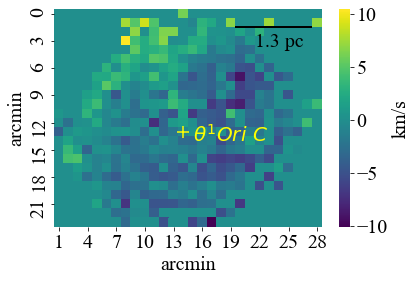

In [5]:
fig, ax = plt.subplots()
sns.heatmap(orion,cmap="viridis",cbar_kws={'label': 'km/s'})
plt.scatter(13.5, 13.5, marker='+', color='yellow', s=150)
ax.set(xlabel='arcmin', ylabel='arcmin')

ax.text(0.93, 0.81, '1.3 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)
    
plt.axhline(y=2, xmin=0.68, xmax=0.96, linewidth=2, color = 'k')

plt.text(14.5, 14.5, '$θ^{1}Ori\ C$', fontsize=20, color='yellow')

plt.show()

In [6]:
df=orion.stack().reset_index().rename(columns={'level_0':'RAdeg', 'level_1':'DEdeg', 0:'RVHalpha'})
df.describe()

,RAdeg,RVHalpha
count,672.000000,672.000000
mean,11.500000,-0.667857
std,6.927343,2.440544
min,0.000000,-10.100000
25%,5.750000,-2.000000
50%,11.500000,0.000000
75%,17.250000,0.000000
max,23.000000,10.400000


In [7]:
df.RAdeg=1.0*df.RAdeg

In [8]:
df.DEdeg=pd.to_numeric(df.DEdeg)*1.0

Structure Function

In [9]:
df0 = pd.DataFrame({'X': df.RAdeg, 'Y': df.DEdeg, 'RV': df.RVHalpha})
df0.describe()

,X,Y,RV
count,672.000000,672.000000,672.000000
mean,11.500000,14.500000,-0.667857
std,6.927343,8.083764,2.440544
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-2.000000
50%,11.500000,14.500000,0.000000
75%,17.250000,21.250000,0.000000
max,23.000000,28.000000,10.400000


In [10]:
df0["RV"] = df0["RV"].replace(['0', 0], np.nan)


In [11]:
df0.describe()

,X,Y,RV
count,672.000000,672.000000,359.000000
mean,11.500000,14.500000,-1.250139
std,6.927343,8.083764,3.230147
min,0.000000,1.000000,-10.100000
25%,5.750000,7.750000,-3.400000
50%,11.500000,14.500000,-1.800000
75%,17.250000,21.250000,0.700000
max,23.000000,28.000000,10.400000


In [12]:
data=df0

Text(0.5, 17.60000000000001, 'Radial velocity [km/s]')

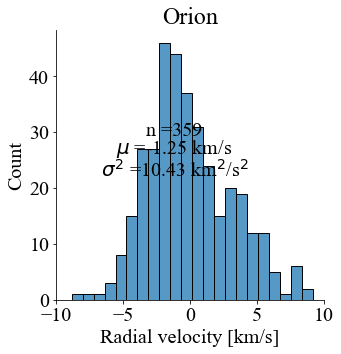

In [13]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-10,10)

plt.text(0.45, 0.86,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.78,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.45, 0.68,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('Orion')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

plt.xlabel('Radial velocity [km/s]')


In [14]:
data.X = data.X*pc
data.Y = data.Y*pc

In [15]:
OrionLH = {'OrionLH' : data,
           'pc' : pc,
          's0' : s0
      }
OrionLH

{'OrionLH':             X         Y  RV
 0    0.000000  0.119264 NaN
 1    0.000000  0.238528 NaN
 2    0.000000  0.357792 NaN
 3    0.000000  0.477057 NaN
 4    0.000000  0.596321 NaN
 ..        ...       ...  ..
 667  2.743076  2.862340 NaN
 668  2.743076  2.981604 NaN
 669  2.743076  3.100868 NaN
 670  2.743076  3.220132 NaN
 671  2.743076  3.339397 NaN
 
 [672 rows x 3 columns],
 'pc': 0.11926416555294585,
 's0': 0.045578661994756374}

In [16]:
import pickle

f = open('VF\\OrionL.pkl',"wb")
pickle.dump(data,f)
f.close()

In [17]:
f = open('VFL\\OrionL.pkl',"wb")
pickle.dump(OrionLH,f)
f.close()

In [18]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 3.832719564437866 seconds ---
